# $\beta$-Pic b planet visualisation
This notebook make plots to visualise the posteriors of the models. They should be as found in the paper of [Sun et al](https://arxiv.org/pdf/2201.08506.pdf)

## Import the necessary packages 

In [1]:
import orbitize
import torch
import matplotlib.pyplot as plt

from orbitize.system import seppa2radec
from orbitize import read_input
from prior import Priors
from simulator import Simulator
from plots import ra_dec_plot
from lampe.plots import nice_rc, corner, mark_point

## Load the dataset with the observations

In [2]:
data_table = read_input.read_file('{}/betaPic.csv'.format(orbitize.DATADIR))

data_table = data_table[:-1] # Discard the  RV observation, don't know how to take it into account

In [3]:
data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant12_corr,quant_type,instrument
float64,int64,float64,float64,float64,float64,float64,bytes5,bytes5
54781.0,1,210.0,27.0,211.49,1.9,nan,seppa,defsp
52953.0,1,413.0,22.0,34.0,4.0,nan,seppa,defsp
55129.0,1,299.0,14.0,211.0,3.0,nan,seppa,defsp
55194.0,1,306.0,9.0,212.1,1.7,nan,seppa,defsp
55296.0,1,346.0,7.0,209.9,1.2,nan,seppa,defsp
55467.0,1,383.0,11.0,210.3,1.7,nan,seppa,defsp
55516.0,1,387.0,8.0,212.4,1.4,nan,seppa,defsp
55517.0,1,390.0,13.0,212.0,2.0,nan,seppa,defsp
55593.0,1,408.0,9.0,211.1,1.5,nan,seppa,defsp


## Define the priors
The priors are defined as such 
$$
\begin{align*}
a &\sim \log \mathcal{U}(4, 40)\\
e &\sim \mathcal{U}(10^{8}, 0.99)\\
i &\sim \mathcal{U}(81,99)\\
\omega &\sim \mathcal{U}(0,360)\\
\Omega &\sim \mathcal{U}(25,85)\\
\tau &\sim \mathcal{U}(0,1)\\
\pi &\sim \mathcal{N}(51.44, 0.12) \\
M_T &\sim \mathcal{N}(0.0,3.0)\\
\end{align*}
$$

In [4]:
prior = Priors()

## Instantiate the simulator

And test if it works well

In [5]:
simulator = Simulator(data_table)

As the RA and DEC measurements are divided by $10^{6}$ in the simulator to suit well in the neural networks we have to increase the precision of the print 

In [6]:
torch.set_printoptions(precision=10)

a: 27.666
e: 0.063
i: 92.445
ω: 275.215
Ω: 69.632
τ: 0.391
π: 51.556
Mt: 0.296


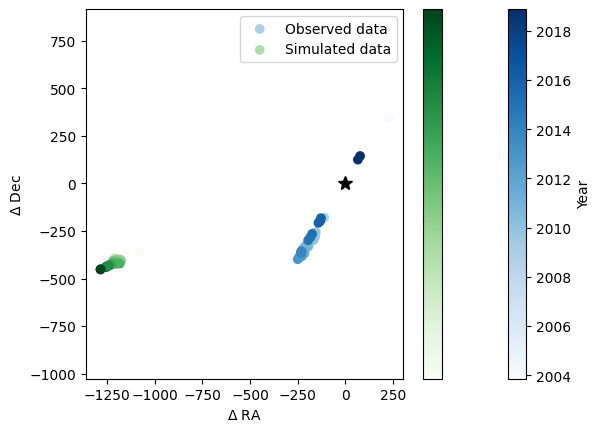

In [8]:
thetas = prior.sample((1,))

x = simulator(thetas) * 1e6 # To get the real values

label_print = ['a', 'e', 'i', 'ω', 'Ω', 'τ', 'π', 'Mt']

for label, theta_value in zip(label_print, thetas[0].tolist()):
    print(f"{label}: {theta_value:.3f}")

ra_dec_plot(x[0][0::2], x[0][1::2], data_table)

## Corner plots

In [9]:
estimator = torch.load("models/bumbling-snowball-45.pth")

In [10]:
quant1 = data_table["quant1"].data 
quant2 = data_table["quant2"].data 

ra, dec = seppa2radec(quant1, quant2) 

x_star = torch.empty(2 * len(ra), dtype=torch.float32)
x_star[0::2] = torch.tensor(ra, dtype=torch.float32) / 1e6
x_star[1::2] = torch.tensor(dec, dtype=torch.float32) / 1e6

x_star = x_star.clone().detach()

In [11]:
with torch.no_grad():
    samples = estimator.flow(x_star.cuda()).sample((2**16,)).cpu()
    samples = prior.post_process(samples)

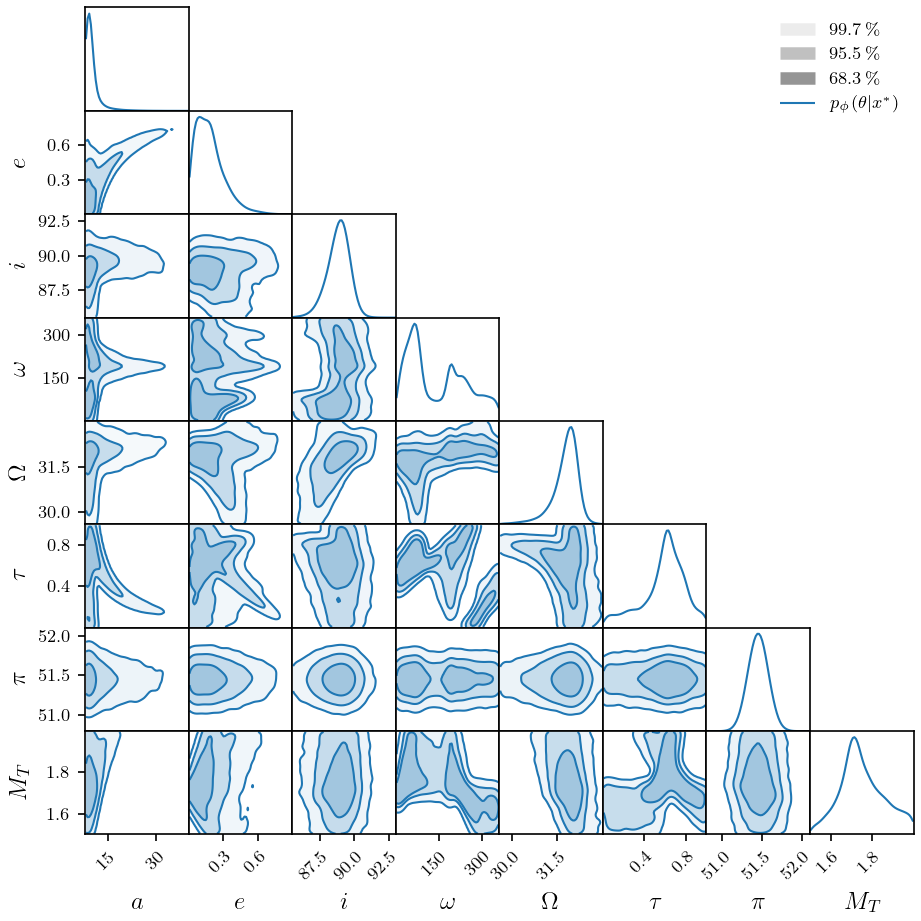

In [20]:
LOWER = torch.tensor([8.0, 0.0, 85.5, 0.0, 29.6, 0.0, 50.8, 1.5])
UPPER = torch.tensor([40.0, 0.9, 93.0, 360.0, 33.0, 1.0, 52.1, 2.0])

LABELS = [r'$a$', r'$e$', r'$i$',
        r'$\omega$', r'$\Omega$',
        r'$\tau$', r'$\pi$', r'$M_T$']

plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    domain=(LOWER, UPPER),
    smooth=2,
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
)

---

In [13]:
from astropy.time import Time
from orbitize.system import seppa2radec
import numpy as np
from orbitize.kepler import calc_orbit

t = Time(data_table['epoch'].data, format='mjd').decimalyear

ra_obs, dec_obs = seppa2radec(data_table['quant1'].data, data_table['quant2'].data)

In [16]:
num_samples = 1000
observation_epochs = np.linspace(51544, 60675, 100)

with torch.no_grad():
    sample = estimator.flow(x_star.cuda()).sample((num_samples,)).cpu()
    sample = prior.post_process(sample)

ra_samples, dec_samples = [], []
for i in range(num_samples): 
    sma, ecc, inc, aop, pan, tau, plx, mtot = sample[i].numpy()
    inc = np.radians(inc)
    aop = np.radians(aop)
    pan = np.radians(pan)
    ra, dec, _ = calc_orbit(observation_epochs, sma, ecc, inc, aop, pan, tau, plx, mtot, tau_ref_epoch=50000)
    ra_samples.append(ra)
    dec_samples.append(dec)

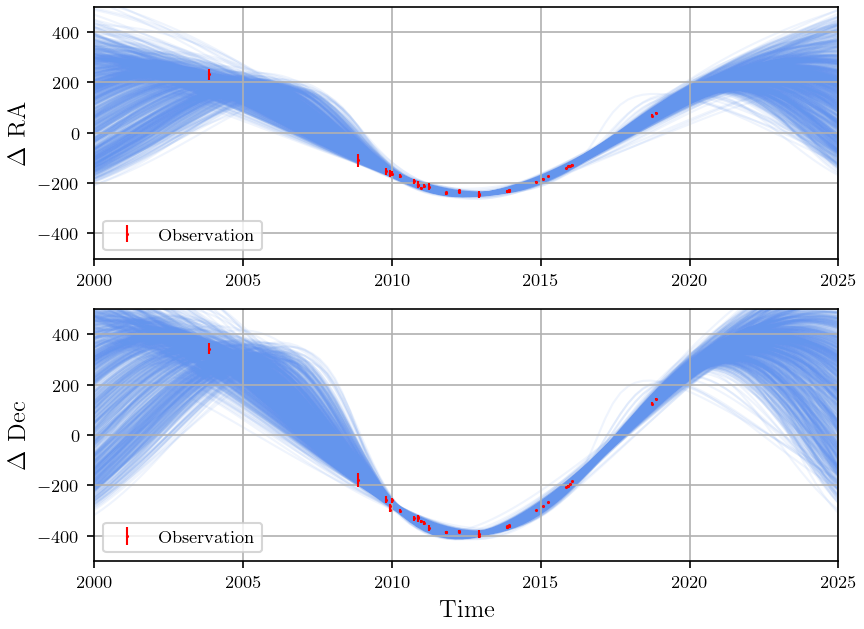

In [17]:
fig, axs = plt.subplots(2)

for i in range(1000):
    axs[0].plot(Time(observation_epochs, format='mjd').decimalyear, ra_samples[i], color="cornflowerblue", alpha=0.1, zorder=0)
    axs[1].plot(Time(observation_epochs, format='mjd').decimalyear, dec_samples[i], color="cornflowerblue", alpha=0.1,zorder=0)
     
axs[0].errorbar(t, ra_obs, yerr=data_table["quant1_err"],color = "r", zorder=1, fmt="o", markersize=0.5, label = "Observation")
axs[0].set_ylabel('$\\Delta$ RA')
axs[0].set_ylim(-500, 500)
axs[0].set_xlim(2000, 2025)
axs[0].grid()
axs[0].legend()

axs[1].errorbar(t, dec_obs, yerr=data_table["quant1_err"],color = "r", zorder=1, fmt="o", markersize=0.5, label = "Observation")
axs[1].set_ylabel('$\\Delta$ Dec')
axs[1].set_ylim(-500, 500)
axs[1].set_xlim(2000, 2025)
axs[1].grid()
axs[1].legend()

axs[1].set_xlabel('Time')


plt.show()

---